<h1>Module 16 Project Template</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [65]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 129,
                "carriages": [],
                "current_status": "STOPPED_AT",
                "current_stop_sequence": 6,
                "direction_id": 1,
                "label": "3277",
                "latitude": 42.3662619,
                "longitude": -71.105194449,
                "occupancy_status": "FEW_SEATS_AVAILABLE",
                "revenue": "REVENUE",
                "speed": null,
                "updated_at": "2024-07-25T16:02:42-04:00"
            },
            "id": "y3277",
            "links": {
                "self": "/vehicles/y3277"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "71",
                        "type": "

Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [168]:
import os
import pymysql
import pandas as pd
import numpy as np

host = '127.0.0.1'
port = 3307
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses", conn)
df['updated_at'] = df['updated_at'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df
# df.tail(10)

C:\Users\andre\AppData\Local\Temp\ipykernel_40964\3390946885.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM mbta_buses", conn)


,record_num,id,latitude,longitude,occupancy_status,current_status,bikes_allowed,headsign,bearing,current_stop_sequence,updated_at
0,1,y3277,42.348192,-71.088809,FULL,STOPPED_AT,1,Harvard,351.0,13.0,2024-07-25 15:28:01-04:00
1,2,y3272,42.337255,-71.077769,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Nubian,140.0,17.0,2024-07-25 15:28:00-04:00
2,3,y3268,42.340720,-71.064160,MANY_SEATS_AVAILABLE,STOPPED_AT,1,Harvard,225.0,1.0,2024-07-25 15:27:56-04:00
3,4,y3265,42.348377,-71.088427,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Nubian,151.0,12.0,2024-07-25 15:27:58-04:00
4,5,y3264,42.336310,-71.076690,FEW_SEATS_AVAILABLE,STOPPED_AT,1,Harvard,315.0,8.0,2024-07-25 15:27:56-04:00
...,...,...,...,...,...,...,...,...,...,...,...
11854,11855,y3264,42.369974,-71.112239,FULL,IN_TRANSIT_TO,1,Harvard,239.0,22.0,2024-07-25 19:15:00-04:00
11855,11856,y3263,42.342215,-71.084161,MANY_SEATS_AVAILABLE,STOPPED_AT,1,Nubian,131.0,14.0,2024-07-25 19:14:56-04:00
11856,11857,y3237,42.363302,-71.100358,FEW_SEATS_AVAILABLE,STOPPED_AT,1,Harvard,309.0,17.0,2024-07-25 19:14:59-04:00
11857,11858,y3211,42.343781,-71.085884,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,1,Nubian,142.0,14.0,2024-07-25 19:14:42-04:00



The code below saves the data as a csv file to the local directory as a backup.

In [142]:

df.to_csv('mbta.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>

In [181]:
def route_times_by_bus_id (bus_id):
    bus_df = df[(df['id'] == bus_id) & (df['current_status'] == 'STOPPED_AT')]
    # print('*********Example bus_df: ', bus_df)

    # remove duplicates
    bus_df = bus_df.drop_duplicates(subset="updated_at")
    bus_df.to_csv('bus_df.csv')

    # WARNING. tracking the bus from 1st stop to last doesn't account for the time it takes to get from the last back to the first.
    route_times = []
    time_at_first_current_stop_sequence = None
    not_in_first_current_stop_sequence = True
    first_current_stop_sequence = 1
    last_current_stop_sequence = 23
    start_latitude = None
    start_longitude = None
    for record in bus_df.to_dict(orient='records'):
        # print(record)
        # when the bus shows it is at the first stop sequence
        if record['current_stop_sequence'] == first_current_stop_sequence:
            # if the bus wasn't previously at the first stop sequence, start the time. Need this because bus could have multiple updates at the same stop
            if not_in_first_current_stop_sequence:
                time_at_first_current_stop_sequence = record["updated_at"]
                start_latitude = record["latitude"]
                start_longitude = record["longitude"]
            not_in_first_current_stop_sequence = False
        # bus is not in the first stop sequence
        else:
            # if the bus reached the end of the route, append the time
            if record['current_stop_sequence'] == last_current_stop_sequence:
                # if it passed the first stop already
                if time_at_first_current_stop_sequence:
                    # if it's the beginning of the day, don't append the time. Should probably have a better way to handle this. Maybe current_status has a status that says it's on break, actually that's what revenue is.
                    if (
                        record["updated_at"] - time_at_first_current_stop_sequence
                    ) < pd.Timedelta("0 days 02:00:00"):
                        route_times.append(
                            {
                                "start_latitude": start_latitude,
                                "start_longitude": start_longitude,
                                "end_latitude": record["latitude"],
                                "end_longitude": record["longitude"],
                                "time_elapsed": record["updated_at"]
                                - time_at_first_current_stop_sequence,
                                "start_time": time_at_first_current_stop_sequence,
                                "bus_id": bus_id,
                            }
                        )
            not_in_first_current_stop_sequence = True

    return route_times

In [182]:
# get all the route times for all the buses
unique_bus_ids = df['id'].unique()

route_times_for_all_buses = []
for bus_id in unique_bus_ids:
    route_times = route_times_by_bus_id(bus_id)
    route_times_for_all_buses.extend(route_times)

# convert to pd.DataFrame
route_times_for_all_buses = pd.DataFrame(route_times_for_all_buses)
# get the average route time
average_route_time = route_times_for_all_buses["time_elapsed"].mean()
print('*********Example average_route_time in minutes: {:.2f}'.format((average_route_time.total_seconds() / 60)))


*********Example average_route_time in minutes: 52.81


<h1>Provide a Visualization based on the data</h1>

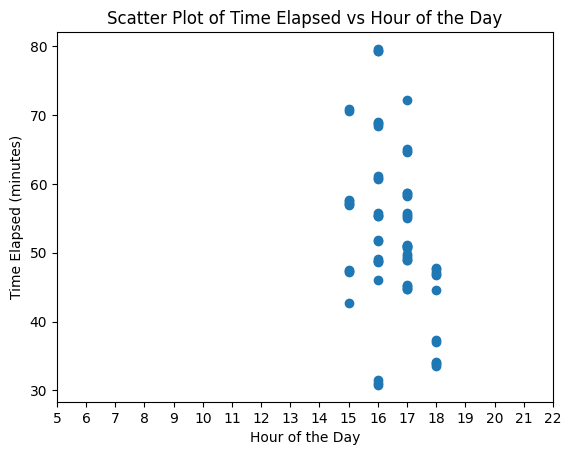

In [183]:
import matplotlib.pyplot as plt


# Extract the hour from the 'start_time' column
route_times_for_all_buses['hour'] = route_times_for_all_buses['start_time'].dt.hour

# Create a scatter plot
plt.scatter(route_times_for_all_buses['hour'], route_times_for_all_buses['time_elapsed'].dt.total_seconds() / 60)

# Set the x-axis and y-axis labels
plt.xlabel('Hour of the Day')
plt.ylabel('Time Elapsed (minutes)')

# Set the x-axis ticks from 5am to 10pm
plt.xticks(range(5, 23))

# Set the title of the plot
plt.title('Scatter Plot of Time Elapsed vs Hour of the Day')

# Show the plot
plt.show()



<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [184]:
route_times_for_all_buses

,start_latitude,start_longitude,end_latitude,end_longitude,time_elapsed,start_time,bus_id,hour
0,42.372917,-71.117887,42.330952,-71.082795,0 days 01:10:40,2024-07-25 15:44:46-04:00,y3277,15
1,42.372917,-71.117887,42.330603,-71.083412,0 days 01:10:52,2024-07-25 15:44:46-04:00,y3277,15
2,42.329884,-71.084101,42.372007,-71.115390,0 days 01:08:27,2024-07-25 16:56:19-04:00,y3277,16
3,42.329884,-71.084101,42.372069,-71.115445,0 days 01:08:40,2024-07-25 16:56:19-04:00,y3277,16
4,42.329884,-71.084101,42.372128,-71.115347,0 days 01:08:48,2024-07-25 16:56:19-04:00,y3277,16
...,...,...,...,...,...,...,...,...
69,42.373010,-71.117474,42.330282,-71.084136,0 days 01:05:03,2024-07-25 17:30:11-04:00,y3286,17
70,42.329977,-71.084492,42.372215,-71.115412,0 days 00:33:36,2024-07-25 18:35:21-04:00,y3286,18
71,42.329977,-71.084492,42.372186,-71.115444,0 days 00:33:47,2024-07-25 18:35:21-04:00,y3286,18
72,42.329977,-71.084492,42.372189,-71.115466,0 days 00:33:59,2024-07-25 18:35:21-04:00,y3286,18


In [190]:
from haversine import haversine

def calculate_average_speed(row):
  start_latitude = row['start_latitude']
  start_longitude = row['start_longitude']
  end_latitude = row['end_latitude']
  end_longitude = row['end_longitude']

  distance = haversine((start_latitude, start_longitude), (end_latitude, end_longitude), unit='mi')
  
  time_elapsed = row['time_elapsed'].total_seconds() / 3600 # convert to hours
  average_speed = distance / time_elapsed
  return average_speed

route_times_for_all_buses['average_speed'] = route_times_for_all_buses.apply(calculate_average_speed, axis=1)
average_speed_all_route_times = route_times_for_all_buses['average_speed'].mean()

average_speed_all_route_times # miles per hour

np.float64(3.9545596258794222)